In [1]:
# Notebook for modelling breakthrough PReCaP
import numpy as np
import matplotlib.pyplot as plt


In [2]:
timesteps = 20
np.random.seed(1)

scc_ests = np.zeros(timesteps)  # scc estimates
scc_stds = np.zeros(timesteps)  # scc standard errors

p_matures = np.zeros(timesteps)  # prices of mature credits
p_breakthroughs = np.zeros(timesteps)  # prices of breakthrough credits
total_costs = np.zeros(timesteps)  # total costs paid for credits
mature_costs = np.zeros(timesteps)  # total costs paid for easy to abate credits
breakthrough_costs = np.zeros(
    timesteps
)  # total costs paid for hard to abate credits
c_matures = np.zeros(timesteps)  # purchased mature credits
c_breakthroughs = np.zeros(timesteps)  # purchased breakthrough credits

em_limits = np.concatenate(
    (np.linspace(1, 0, timesteps // 2), np.zeros(timesteps // 2)), axis=0
)  # carbon emissions limits
emissions = np.linspace(100, 200, num=timesteps)  # initial emissions

em_easy = 0.7  # easy to abate proportion of emissions
discount_rate = 0.985  # discount rate, yearly
true_scc = 1000  # True scc in BAU scenario
scc_est_0 = 150  # initial scc estimate
scc_std_0 = 50  # initial scc standard error
p_mature_0 = 100  # initial price of mature credits
p_breakthrough_0 = 300  # initial price of breakthrough credits


In [3]:
def _easy_emissions(emissions, em_easy):
    """
    Calculate emissions that are easy to abate
    Inputs:
        - emissions, timeseries of emissions
        - em_easy, proportion of easy to abate emissions
    Outputs:
        - easy_emissions, timeseries of easy to abate emissions
    """
    return emissions * em_easy  # placeholder


def _hard_emissions(emissions, em_easy):
    """
    Calculate emissions that are easy to abate
    Inputs:
        - emissions, timeseries of emissions
        - em_easy, proportion of easy to abate emissions
    Outputs:
        - easy_emissions, timeseries of hard to abate emissions
    """
    return emissions * (1 - em_easy)  # placeholder


In [4]:
def update_scc_est(true_scc, scc_est, scc_std):
    """
    Update the scc estimate
    """

    return scc_est_0 + np.random.randn() * scc_std  # placeholder


def update_p_mature(p_mature, c_mature):
    """
    Calculate the new price of mature credits based on purchased credits.
    Based on experience curves
    Inputs:
        - p_mature, current price of mature credits
        - c_mature, current purchased carbon credits
    Outputs:
        - p_mature_new, updated price of mature credits
    """
    return (1 / (1 + np.log(1 + c_mature))) * p_mature  # placeholder


def update_p_breakthrough(p_breakthrough, c_breakthrough):
    """
    Calculate the new price of breakthrough credits based on purchased credits.
    Based on experience curves
    Inputs:
        - p_mature, current price of breakthrough credits
        - c_mature, current purchased carbon credits
    Outputs:
        - p_mature_new, updated price of breakthrough credits
    """
    return (
        1 / (1 + np.log(1 + c_breakthrough))
    ) * p_breakthrough  # placeholder


In [5]:
def purchase_credits(
    em_limit,
    easy_emissions,
    hard_emissions,
    p_mature,
    p_breakthrough,
    discount_rate,
    solver=None,
):
    """
    Wrapper for deciding the purchase of credits at a given timestep.
    Assumption: agent is myopic and optimizes only the current timestep.
    Currently, does not use the discount rate for optimization.
    Inputs: ...
    Outputs: ...
    """

    required_abatement = (1 - em_limit) * (easy_emissions + hard_emissions)

    if solver == None:
        print(
            'need to specify a solver for credit purchasing! Options: "greedy", "discounted", "precap", or specify a `solver` function'
        )

    elif solver == "greedy":
        c_mature = min(
            easy_emissions, required_abatement
        )  # buy max of mature credits
        c_breakthrough = (
            required_abatement - c_mature
        )  # rest is breakthrough credits

    elif solver == "discounted":
        print("discounted solver not yet implemented!")

    elif solver == "precap":
        c_mature = min(
            easy_emissions, required_abatement
        )  # buy max of mature credits
        c_breakthrough = (
            required_abatement - c_mature
        )  # rest is breakthrough credits

        if c_breakthrough <= 0.1 * c_mature:
            c_breakthrough = 0.1 * c_mature
            c_mature *= 0.9

    else:
        try:
            c_mature, c_breakthrough = solver(
                required_abatement,
                easy_emissions,
                hard_emissions,
                p_mature,
                p_breakthrough,
                discount_rate,
            )
        except:
            print(
                'please read docstring for purchase_credits'
            )


    mature_cost = c_mature * p_mature
    breakthrough_cost = c_breakthrough * p_breakthrough
    total_cost = c_mature * p_mature + c_breakthrough * p_breakthrough

    return c_mature, c_breakthrough, mature_cost, breakthrough_cost


In [6]:
def plot_graphs(
    c_matures,
    c_breakthroughs,
    p_matures,
    p_breakthroughs,
    scc_ests,
    scc_stds,
    mature_costs,
    breakthrough_costs,
    total_costs,
):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    axes[0, 0].plot(c_matures, label="mature credits, quantity")
    axes[0, 0].plot(c_breakthroughs, label="breakthrough credits, quantity")
    axes[0, 0].legend()
    axes[0, 0].set_xlabel("timestep")
    axes[0, 0].set_ylabel("credits")

    axes[1, 0].plot(p_matures, label="mature credits, price")
    axes[1, 0].plot(p_breakthroughs, label="breakthrough credits, price")
    axes[1, 0].legend()
    axes[1, 0].set_xlabel("timestep")
    axes[1, 0].set_ylabel("dollars")

    axes[0, 1].plot(scc_ests, label="SCC estimates")
    axes[0, 1].fill_between(
        range(timesteps),
        scc_ests + scc_stds,
        scc_ests - scc_stds,
        color="blue",
        alpha=0.05,
        label="SCC uncertainty",
    )
    axes[0, 1].legend()
    axes[0, 1].set_xlabel("timestep")
    axes[0, 1].set_ylabel("dollars")

    axes[1, 1].plot(mature_costs, label="mature credit costs")
    axes[1, 1].plot(breakthrough_costs, label="breakthrough credit costs")
    axes[1, 1].plot(total_costs, label="total costs", color="red")
    axes[1, 1].legend()
    axes[1, 1].set_xlabel("timestep")
    axes[1, 1].set_ylabel("dollars")


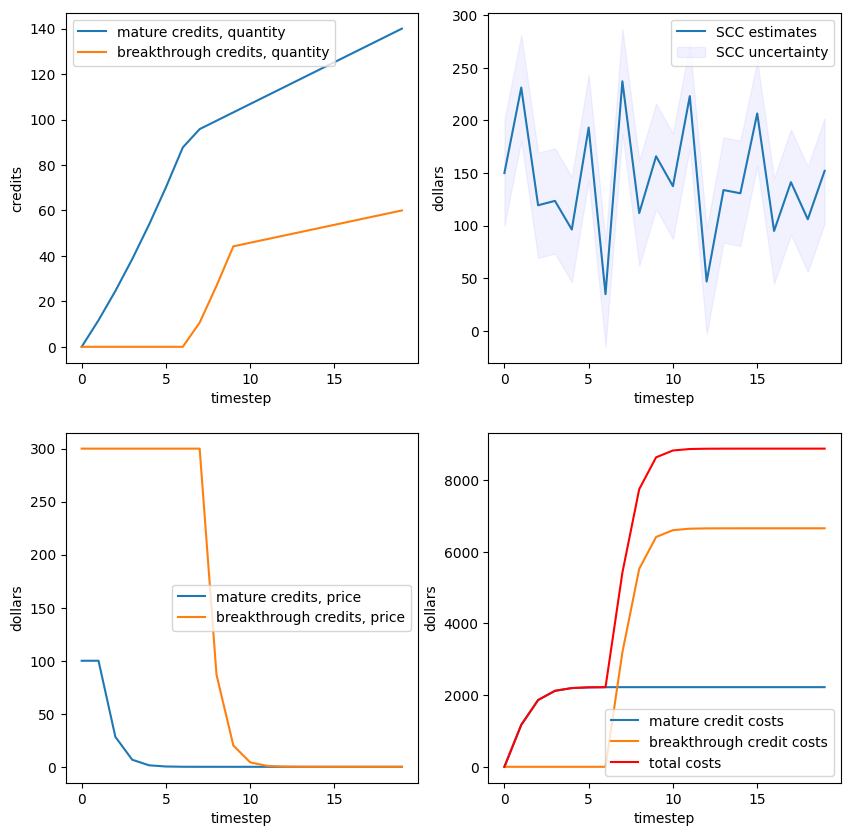

In [7]:
scc_est = scc_est_0
scc_std = scc_std_0
p_mature = p_mature_0
p_breakthrough = p_breakthrough_0

metrics_greedy ={}

for step, em_limit in enumerate(em_limits):
    emission = emissions[step]
    easy_emissions = _easy_emissions(emission, em_easy)
    hard_emissions = _hard_emissions(emission, em_easy)

    c_mature, c_breakthrough, mature_cost, breakthrough_cost = purchase_credits(
        solver="greedy",
        em_limit=em_limit,
        easy_emissions=easy_emissions,
        hard_emissions=hard_emissions,
        p_mature=p_mature,
        p_breakthrough=p_breakthrough,
        discount_rate=discount_rate,
    )

    # log variables
    scc_ests[step] = scc_est
    scc_stds[step] = scc_std

    p_matures[step] = p_mature
    p_breakthroughs[step] = p_breakthrough

    c_matures[step] = c_mature
    c_breakthroughs[step] = c_breakthrough

    mature_costs[step] = (
        mature_costs[step - 1] + mature_cost if step >= 1 else mature_cost
    )
    breakthrough_costs[step] = (
        breakthrough_costs[step - 1] + breakthrough_cost if step >= 1 else breakthrough_cost
    )

    total_cost = mature_cost + breakthrough_cost
    total_costs[step] = (
        total_costs[step - 1] + total_cost if step >= 1 else total_cost
    )

    # update variables
    scc_est = update_scc_est(true_scc, scc_est, scc_std)
    p_mature = update_p_mature(p_mature, c_mature)
    p_breakthrough = update_p_breakthrough(p_breakthrough, c_breakthrough)



for metric in metrics:
plot_graphs(
    c_matures,
    c_breakthroughs,
    p_matures,
    p_breakthroughs,
    scc_ests,
    scc_stds,
    mature_costs,
    breakthrough_costs,
    total_costs,
)


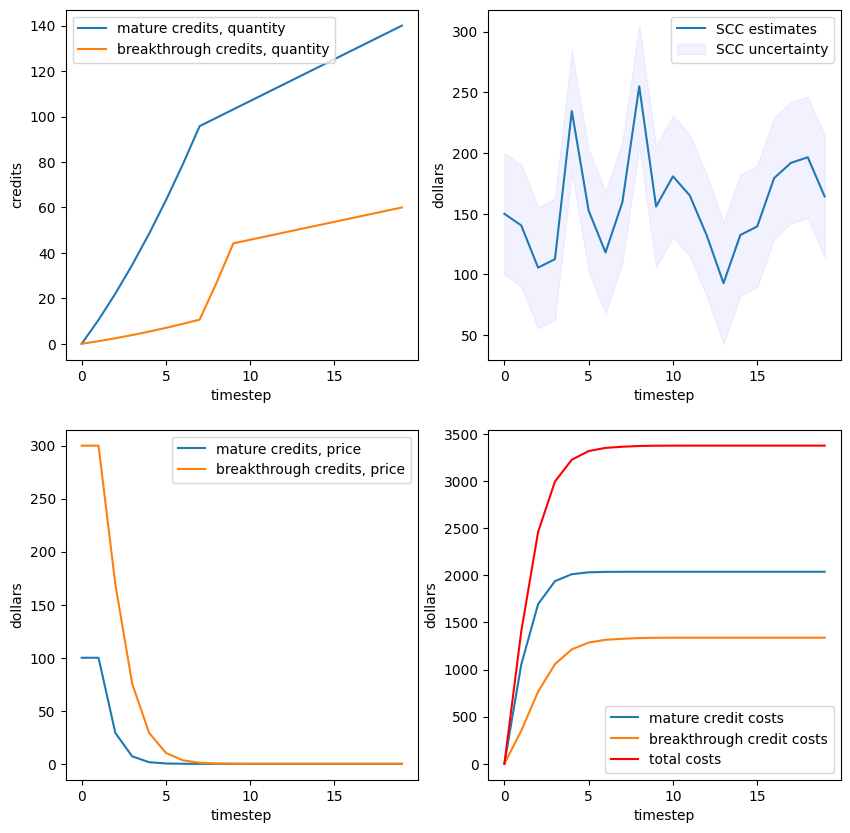

In [43]:
scc_est = scc_est_0
scc_std = scc_std_0
p_mature = p_mature_0
p_breakthrough = p_breakthrough_0

for step, em_limit in enumerate(em_limits):
    emission = emissions[step]
    easy_emissions = _easy_emissions(emission, em_easy)
    hard_emissions = _hard_emissions(emission, em_easy)

    c_mature, c_breakthrough, mature_cost, breakthrough_cost = purchase_credits(
        solver="precap",
        em_limit=em_limit,
        easy_emissions=easy_emissions,
        hard_emissions=hard_emissions,
        p_mature=p_mature,
        p_breakthrough=p_breakthrough,
        discount_rate=discount_rate,
    )

    # log variables
    scc_ests[step] = scc_est
    scc_stds[step] = scc_std

    p_matures[step] = p_mature
    p_breakthroughs[step] = p_breakthrough

    c_matures[step] = c_mature
    c_breakthroughs[step] = c_breakthrough

    mature_costs[step] = (
        mature_costs[step - 1] + mature_cost if step >= 1 else mature_cost
    )
    breakthrough_costs[step] = (
        breakthrough_costs[step - 1] + breakthrough_cost if step >= 1 else breakthrough_cost
    )

    total_cost = mature_cost + breakthrough_cost
    total_costs[step] = (
        total_costs[step - 1] + total_cost if step >= 1 else total_cost
    )

    # update variables
    scc_est = update_scc_est(true_scc, scc_est, scc_std)
    p_mature = update_p_mature(p_mature, c_mature)
    p_breakthrough = update_p_breakthrough(p_breakthrough, c_breakthrough)

plot_graphs(
    c_matures,
    c_breakthroughs,
    p_matures,
    p_breakthroughs,
    scc_ests,
    scc_stds,
    mature_costs,
    breakthrough_costs,
    total_costs,
)
